In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
from scipy.signal import savgol_filter
import numpy as np
import statsmodels.api as sm

In [ ]:
# Reading Grouped Sentiment DF (no Risk disclosure data)
# try reading riskcomm data if not uploaded (same df with added risk comm column)
sentiment_df = pd.read_excel('df_env_risk_tone_grouped.xlsx')  

# change negative Sentiment to 0, neutral to 1 and positive to 2
sentiment_df['full_sentiment_id'] = sentiment_df['full_sentiment_id'].replace({0: 1, 2: 0, 1: 2})



In [ ]:
sentiment_df.describe(include='all')

# descriptives for sentiment



,cik,FiscalYearEnd,text,sentence_order,dict_label,baseline_label,doc_id,label,sentiment_id,sentiment,full_text,full_sentiment_id,full_sentiment
count,2.577000e+03,2577,2577,2577,2577,2577,2577,2577,2577,2577,2577,2577.000000,2577
unique,NaN,467,2577,2232,869,917,2577,95,985,985,2577,NaN,3
top,NaN,2024-12-31 00:00:00,['· Changes in or interpretations of laws and ...,[77],[0],[0],['1800_2006-12-31'],[1],[2],['Negative'],· Changes in or interpretations of laws and re...,NaN,Negative
freq,NaN,120,1,8,427,433,1,590,336,336,1,NaN,2026
mean,5.002072e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.218471,NaN
std,4.638720e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.424411,NaN
min,1.800000e+03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN
25%,5.578500e+04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN
50%,3.181540e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN
75%,9.061070e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN


In [ ]:
# import cik and industries for sector classification
cik_industry_df = pd.read_csv('cik_and_Sector.csv')  
cik_industry_df = cik_industry_df[['cik', 'sector']]

In [448]:
# add column sector to sentiment_df
sector_map = cik_industry_df.drop_duplicates('cik').set_index('cik')['sector']
sentiment_df['sector'] = sentiment_df['cik'].map(sector_map)

# missing ones are 'Energy'
sentiment_df['sector'] = sentiment_df['sector'].fillna('Energy')

(0.0, 2.1)

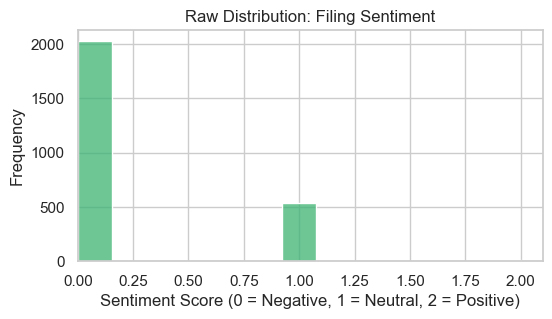

In [ ]:
# Distributions
sns.set_theme(style="whitegrid")


# 1. raw fistribution on sentence_count
plt.figure(figsize=(6,3))
sns.histplot(sentiment_df['full_sentiment_id'].dropna(), color="mediumseagreen")
plt.title('Raw Distribution: Filing Sentiment')
plt.xlabel('Sentiment Score (0 = Negative, 1 = Neutral, 2 = Positive)')
plt.ylabel('Frequency')
plt.xlim(left=0)

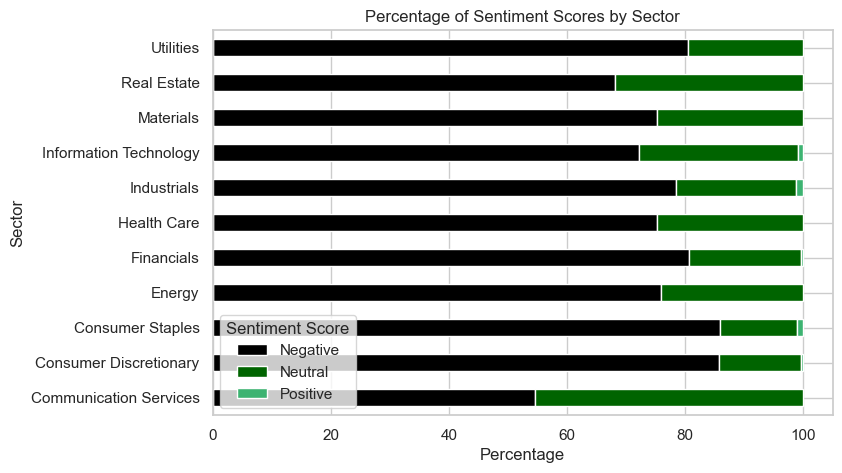

In [ ]:
# color bar chart and extract counts
counts = pd.crosstab(sentiment_df['sector'], sentiment_df['full_sentiment_id'])
colors = {
    0: 'black',
    1: 'darkgreen',
    2: 'mediumseagreen'
}
labels = ['Negative', 'Neutral', 'Positive']
# values in percent
counts_percent = counts.div(counts.sum(axis=1), axis=0) * 100


# horizontal bar chart
counts_percent.plot(kind='barh', stacked=True, figsize=(8,5), color=[colors[col] for col in counts.columns])
plt.title('Percentage of Sentiment Scores by Sector')
plt.xlabel('Percentage')
plt.ylabel('Sector')
plt.legend(title='Sentiment Score', loc='lower left', labels=labels)
plt.show()


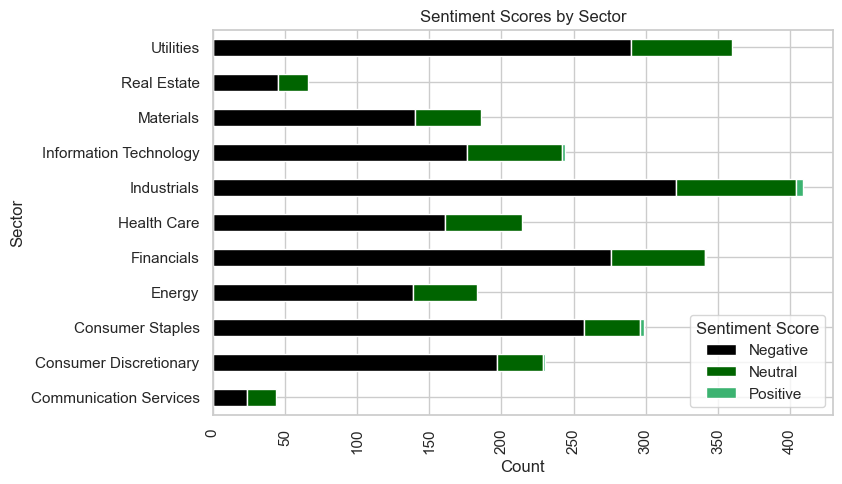

In [ ]:
# horizontal bar chart (counts)

counts = pd.crosstab(sentiment_df['sector'], sentiment_df['full_sentiment_id'])

counts.plot(kind='barh', stacked=True, figsize=(8,5), color=[colors[col] for col in counts.columns])
plt.title('Sentiment Scores by Sector')
plt.xlabel('Count')
plt.ylabel('Sector')
plt.xticks(rotation = 90)
plt.legend(title='Sentiment Score',labels=labels )
plt.show()


C:\Users\TG2023\AppData\Local\Temp\ipykernel_23220\2386200015.py:6: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  pd.Grouper(key='FiscalYearEnd', freq='Y'),


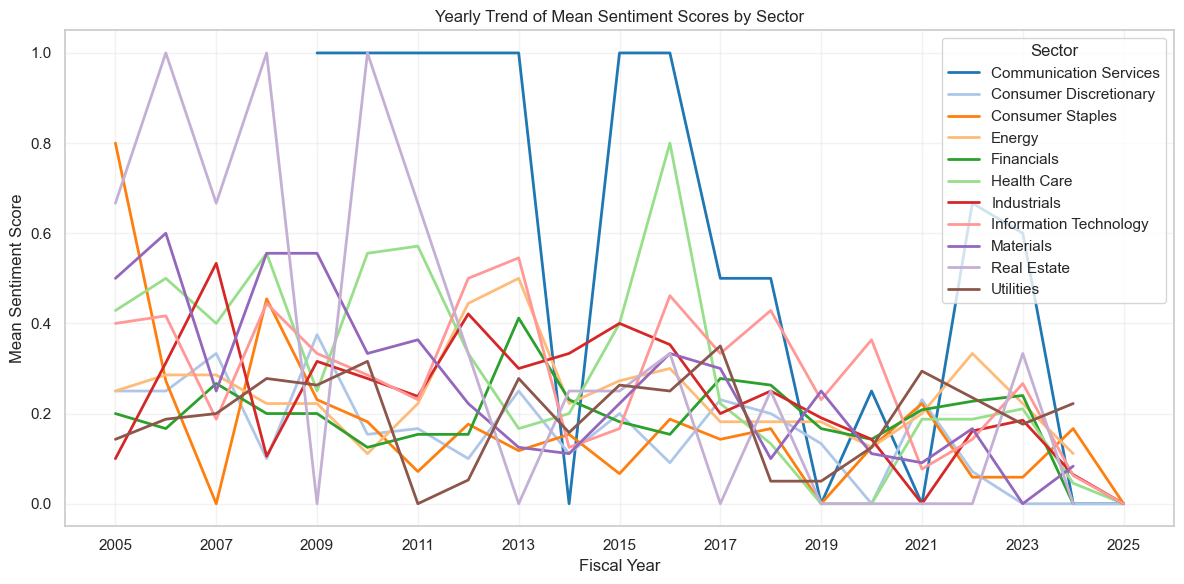

In [ ]:
# to datetime
sentiment_df['FiscalYearEnd'] = pd.to_datetime(sentiment_df['FiscalYearEnd'])

# calculate yearly means
pivot_yearly = sentiment_df.groupby([
    pd.Grouper(key='FiscalYearEnd', freq='Y'),
    'sector'
])['full_sentiment_id'].mean().unstack()
# plot mean sentiment by sector
plt.figure(figsize=(12,6))
colors = sns.color_palette("tab20", n_colors=len(pivot_yearly.columns))
years = pivot_yearly.index.year
plt.xticks(years[::2])
for col, c in zip(pivot_yearly.columns, colors):
    plt.plot(pivot_yearly.index.year, pivot_yearly[col],  linewidth=2, label=col, color=c)

plt.title('Yearly Trend of Mean Sentiment Scores by Sector')
plt.xlabel('Fiscal Year')
plt.ylabel('Mean Sentiment Score')
plt.legend(title='Sector')
plt.grid(alpha=0.25)
plt.tight_layout()
plt.show()


C:\Users\TG2023\AppData\Local\Temp\ipykernel_23220\2505175228.py:6: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  yearly_avg = sentiment_df.groupby(pd.Grouper(key='FiscalYearEnd', freq='Y'))['full_sentiment_id'].mean()


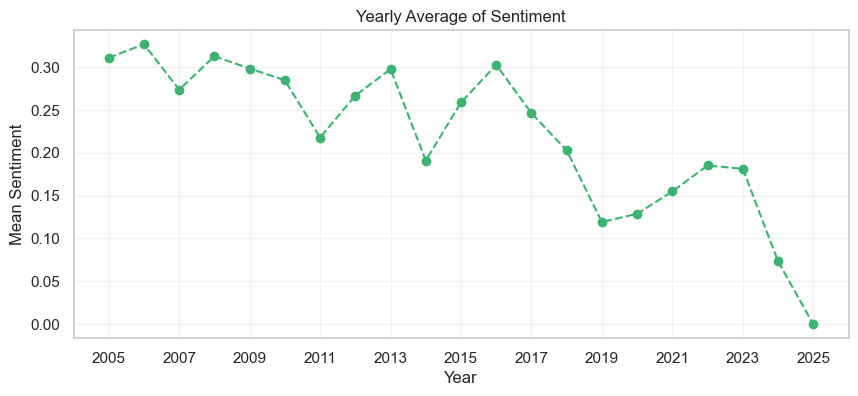

In [ ]:
# Time Series aggregated by Yearly average, Monthly average and daily average
sentiment_df['FiscalYearEnd'] = pd.to_datetime(sentiment_df['FiscalYearEnd'])

yearly_avg = sentiment_df.groupby(pd.Grouper(key='FiscalYearEnd', freq='Y'))['full_sentiment_id'].mean()
# yearly average plot
plt.figure(figsize=(10,4))
years = pivot_yearly.index.year
plt.xticks(years[::2])
plt.plot(yearly_avg.index.year, yearly_avg,marker='o', color="mediumseagreen",linestyle="--")
plt.title('Yearly Average of Sentiment')
plt.xlabel('Year')
plt.ylabel('Mean Sentiment')
plt.grid(alpha=0.25)
plt.show()


C:\Users\TG2023\AppData\Local\Temp\ipykernel_23220\1968510759.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_avg = sentiment_df.groupby(pd.Grouper(key='FiscalYearEnd', freq='M'))['full_sentiment_id'].mean()


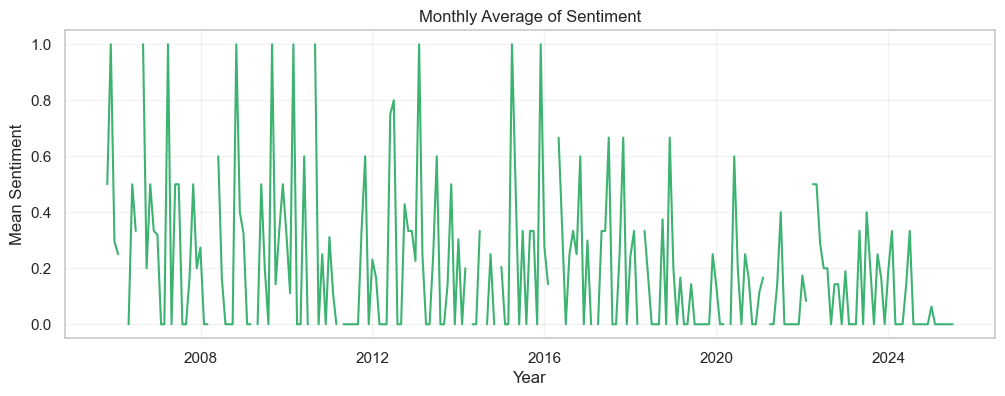

In [ ]:
# monthly average plot
monthly_avg = sentiment_df.groupby(pd.Grouper(key='FiscalYearEnd', freq='M'))['full_sentiment_id'].mean()

plt.figure(figsize=(12,4))
plt.plot(monthly_avg.index, monthly_avg,  color="mediumseagreen")
plt.title('Monthly Average of Sentiment')
plt.xlabel('Year')
plt.ylabel('Mean Sentiment')
plt.grid(alpha=0.25)
plt.show()


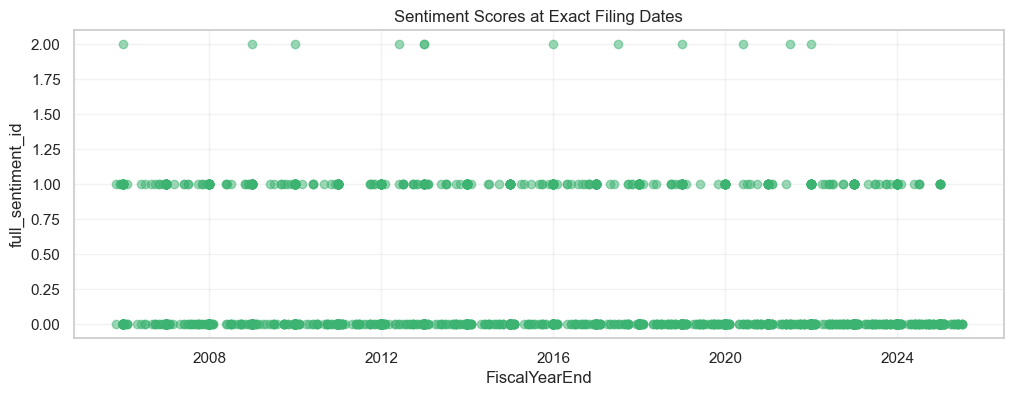

In [ ]:
# plot of all observations (not good)
plt.figure(figsize=(12,4))
plt.plot(sentiment_df['FiscalYearEnd'], sentiment_df['full_sentiment_id'], 'o',  color="mediumseagreen" ,alpha=0.5)
plt.title('Sentiment Scores at Exact Filing Dates')
plt.xlabel('FiscalYearEnd')
plt.ylabel('full_sentiment_id')
plt.grid(alpha=0.25)
plt.show()


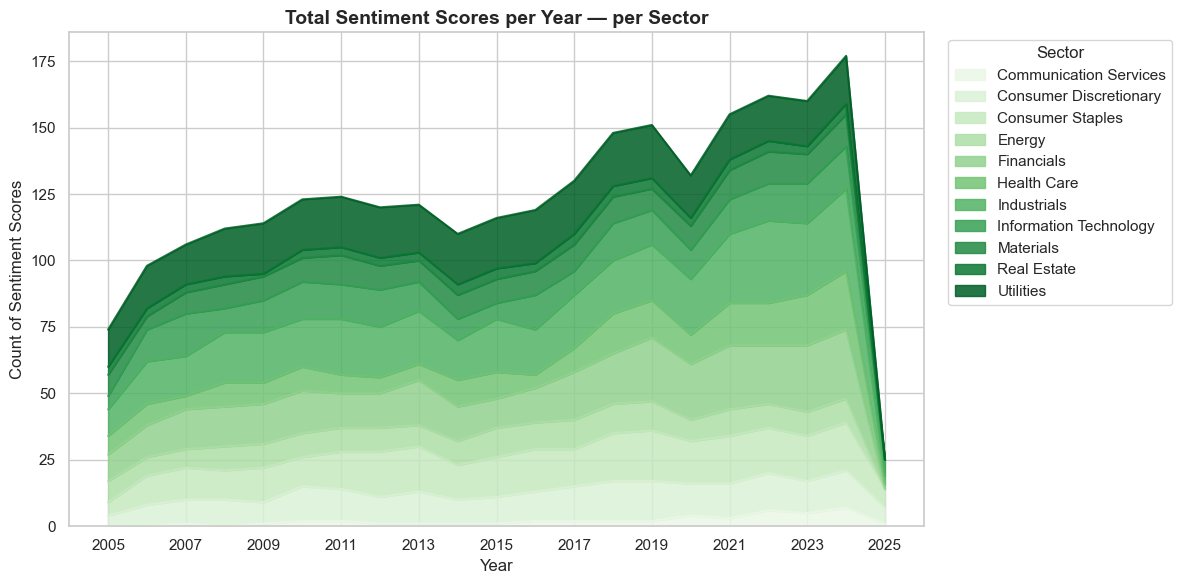

In [ ]:

# stacked chart total sentiments per year and sector
sns.set_style("whitegrid")

# FiscalYearEnd in datetime
sentiment_df['FiscalYearEnd'] = pd.to_datetime(sentiment_df['FiscalYearEnd'])

# only extract year
sentiment_df['Year'] = sentiment_df['FiscalYearEnd'].dt.year

# Pivot:sentiment per year and sector
totals = (
    sentiment_df.groupby(['Year','sector'])['full_sentiment_id']
    .count()
    .reset_index()
    .pivot(index='Year', columns='sector', values='full_sentiment_id')
    .fillna(0)
)

palette = sns.color_palette("Greens", n_colors=len(totals.columns))

plt.figure(figsize=(12,6))
years = pivot_yearly.index.year
plt.xticks(years[::2])
totals.plot.area(ax=plt.gca(), stacked=True, color=palette, alpha=0.85)
plt.title('Total Sentiment Scores per Year — per Sector', fontsize=14, fontweight='bold')
plt.xlabel('Year', fontsize=12)
plt.ylabel('Count of Sentiment Scores', fontsize=12)
plt.legend(title='Sector', bbox_to_anchor=(1.02,1), loc='upper left')
plt.tight_layout()
plt.show()


In [ ]:
# Import Regulations and Events Timeline (delete last 3 rows in events csv, as they are just description of sources of contents
events = pd.read_csv("Events - Sheet1.csv")
regulations = pd.read_csv("Regulations - Sheet1.csv")
events = events.iloc[:-3]



In [ ]:
# convert to timedate type



events['Date '] = pd.to_datetime(events['Date '], format="%d-%m-%Y", errors='coerce')  # converts invalid to NaT
regulations['Date '] = pd.to_datetime(events['Date '], format="%d-%m-%Y", errors='coerce')  # converts invalid to NaT
# check proper import
print(events)


        Date                          Event   \
0  2004-09-21                 Hurricane Ivan   
1  2005-08-30              Hurricane Katrina   
2  2005-10-08             Kashmir Earthquake   
3  2007-11-16                   Cyclone Sidr   
4  2008-05-03                 Cyclone Nargis   
5  2008-09-14                  Hurricane Ive   
6  2010-01-12              Earthquake Haiti    
7  2011-03-11  Tsunami and Earthquake Japan    
8  2012-10-31               Hurricane Sandy    
9  2017-09-14                  Hurricanes US   
10 2018-09-16            Hurricane Florence    
11 2018-12-31          California wildfires    
12 2021-02-19               Winter storms US   
13 2021-09-01                  Hurricane Ida   
14 2022-09-08                  Hurricane Ian   
15 2023-02-06   Earthquake Syria and turkey    
16 2024-09-29              Hurricane Helene    

                                    Description  In_usa  
0           Cyclone - 34 bio$ damage - 57 dead      1.0  
1               Cyc

In [ ]:
# Time Series aggregate by time for later use
# month
ts = sentiment_df.copy()
ts['FiscalYearEnd'] = pd.to_datetime(ts['FiscalYearEnd'])
ts.set_index('FiscalYearEnd', inplace=True)

ts['YearMonth'] = ts.index.to_period('M').to_timestamp()

#year
ts['Year'] = ts.index.to_period('Y').to_timestamp()

# aggregate monthly
numeric_cols = ts.select_dtypes(include='number').columns
ts_month = ts.groupby('YearMonth')[numeric_cols].mean()

# aggreagate yearly
ts_year = ts.groupby('Year')[numeric_cols].mean()





In [ ]:
# same for events df
events['Date '] = pd.to_datetime(events['Date '])
events.set_index('Date ', inplace=True)

events['YearMonth'] = events.index.to_period('M').to_timestamp()

# Jahresspalte
events['Year'] = events.index.to_period('Y').to_timestamp()

# Danach monatlich aggregieren
numeric_cols = events.select_dtypes(include='number').columns
events_month = events.groupby('YearMonth')[numeric_cols].mean()

# Jährlich aggregieren
events_year = events.groupby('Year')[numeric_cols].mean()


In [ ]:
# same for regulations df


regulations['Date'] = regulations['Date'].replace('16-2-2005', '16-02-2005')

regulations['Date'] = pd.to_datetime(regulations['Date'], dayfirst = True)

regulations.set_index('Date', inplace=True)

regulations['YearMonth'] = regulations.index.to_period('M').to_timestamp()

# Jahresspalte
regulations['Year'] = regulations.index.to_period('Y').to_timestamp()

# Danach monatlich aggregieren
numeric_cols = regulations.select_dtypes(include='number').columns
regulations_month = regulations.groupby('YearMonth')[numeric_cols].mean()

# Jährlich aggregieren
regulations_year = regulations.groupby('Year')[numeric_cols].mean()


In [ ]:
# preparation SARIMAX
full_month_index = ts_month.index
full_year_index = ts_year.index

In [470]:

events['event'] = 1  # mark event occurrence
events_month = events.set_index('YearMonth', inplace=True)
events_month_full = events.reindex(full_month_index, fill_value=0)


In [471]:
events_year = events.copy()
events_year
events_year_full = events_year.reindex(full_year_index, fill_value=0)

In [472]:

regulations['regulation'] = 1  # mark event occurrence
regulations_month = regulations.set_index('YearMonth', inplace=True)
regulations_month_full = regulations.reindex(full_month_index, fill_value=0)

regulations_year = regulations.copy()
regulations_year
regulations_year_full = regulations_year.reindex(full_year_index, fill_value=0)

In [ ]:
# fill nans with 0 - no  Nans allowed for sarimax

ts_month['event_next_month'] = events_month_full['event'].shift(1).fillna(0)
ts_month['regulation_next_month'] = regulations_month_full['regulation'].shift(1).fillna(0)

ts_year['event_next_year'] = events_year_full['event'].shift(1).fillna(0)
ts_year['regulation_next_year'] = regulations_year_full['regulation'].shift(1).fillna(0)



In [ ]:
# SARIMAX analysis exogenous variables = events or regulation (one each) lags = 1 month or 1 year

# --- Monatsmodell: Events ---
model_events_month = SARIMAX(
    ts_month['full_sentiment_id'],
    exog=ts_month[['event_next_month']],
    order=(1,0,0)
)
result_events_month = model_events_month.fit()
print("Monatsmodell - Events")
print(result_events_month.summary())

# --- Monatsmodell: Regulations ---

model_reg_month = SARIMAX(
    ts_month['full_sentiment_id'],
    exog=ts_month[['regulation_next_month']],
    order=(1,0,0)
)
result_reg_month = model_reg_month.fit()
print("Monatsmodell - Regulations")
print(result_reg_month.summary())

# --- Jahresmodell: Events ---

model_events_year = SARIMAX(
    ts_year['full_sentiment_id'],
    exog=ts_year[['event_next_year']],
    order=(1,0,0)
)
result_events_year = model_events_year.fit()
print("Jahresmodell - Events")
print(result_events_year.summary())

# --- Jahresmodell: Regulations ---

model_reg_year = SARIMAX(
    ts_year['full_sentiment_id'],
    exog=ts_year[['regulation_next_year']],
    order=(1,0,0)
)
result_reg_year = model_reg_year.fit()
print("Jahresmodell - Regulations")
print(result_reg_year.summary())


Monatsmodell - Events
                               SARIMAX Results                                
Dep. Variable:      full_sentiment_id   No. Observations:                  219
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 -45.639
Date:                 So, 31 Aug 2025   AIC                             97.278
Time:                        13:40:50   BIC                            107.445
Sample:                             0   HQIC                           101.384
                                - 219                                         
Covariance Type:                  opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
event_next_month     0.2347      0.062      3.766      0.000       0.113       0.357
ar.L1                0.3606      0.079      4.550      0.000       0.205       0.516
sigma2

c:\Users\TG2023\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\TG2023\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\TG2023\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\TG2023\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(d

In [ ]:
# SARIMAX analysis exogenous variables = events or regulation (one each) lags = 1 month up to 6 months (incrementing by one month each)

# --- Events für 6 Monate vorbereiten ---
for i in range(1, 7):
    ts_month[f'event_next_{i}month'] = events_month_full['event'].shift(i).fillna(0)

event_exog_cols = [f'event_next_{i}month' for i in range(1, 7)]

# SARIMAX für Events
model_events_6m = SARIMAX(ts_month['full_sentiment_id'],
                          exog=ts_month[event_exog_cols],
                          order=(1,0,0))
result_events_6m = model_events_6m.fit()
print("Monatliches Modell - Events (6 Monate):")
print(result_events_6m.summary())

# --- Regulations für 6 Monate vorbereiten ---
for i in range(1, 7):
    ts_month[f'regulation_next_{i}month'] = regulations_month_full['regulation'].shift(i).fillna(0)

reg_exog_cols = [f'regulation_next_{i}month' for i in range(1, 7)]

# SARIMAX für Regulations
model_reg_6m = SARIMAX(ts_month['full_sentiment_id'],
                        exog=ts_month[reg_exog_cols],
                        order=(1,0,0))
result_reg_6m = model_reg_6m.fit()
print("Monatliches Modell - Regulations (6 Monate):")
print(result_reg_6m.summary())


Monatliches Modell - Events (6 Monate):
                               SARIMAX Results                                
Dep. Variable:      full_sentiment_id   No. Observations:                  219
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 -41.844
Date:                 So, 31 Aug 2025   AIC                             99.687
Time:                        13:40:53   BIC                            126.800
Sample:                             0   HQIC                           110.637
                                - 219                                         
Covariance Type:                  opg                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
event_next_1month     0.2645      0.067      3.954      0.000       0.133       0.396
event_next_2month     0.1215      0.104      1.174      0.240      -0.

c:\Users\TG2023\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\TG2023\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\TG2023\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\TG2023\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(d

In [ ]:


# Load regulations

regulations.set_index('Date ', inplace=True)
# Create exogenous variable
ts['event'] = ts.index.isin(regulations.index).astype(int)



# Fit SARIMAX with event as exogenous
model = SARIMAX(ts['full_sentiment_id'], exog=ts[['event']], order=(1,0,0))  
result = model.fit()
print(result.summary())


                               SARIMAX Results                                
Dep. Variable:      full_sentiment_id   No. Observations:                 2577
Model:               SARIMAX(1, 0, 0)   Log Likelihood               -1527.456
Date:                 So, 31 Aug 2025   AIC                           3060.912
Time:                        13:40:56   BIC                           3078.475
Sample:                             0   HQIC                          3067.279
                               - 2577                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
event          0.1042      0.282      0.369      0.712      -0.449       0.657
ar.L1          0.3983      0.015     25.816      0.000       0.368       0.428
sigma2         0.1916      0.004     52.748      0.0

c:\Users\TG2023\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\TG2023\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\TG2023\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\TG2023\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Risk Communication 


In [ ]:
# importing riskrelated data
riskcomm_df = pd.read_excel('df_envrisk_riskcomm_grouped.xlsx')  


In [ ]:
# descriptive analysis
riskcomm_df.describe(include='all')

,cik,FiscalYearEnd,text,sentence_order,dict_label,baseline_label,doc_id,label,sentiment_id,sentiment,full_text,full_sentiment_id,full_sentiment,Risk_comm_active
count,2.577000e+03,2577,2577,2577,2577,2577,2577,2577,2577,2577,2577,2577.000000,2577,2577.000000
unique,NaN,467,2577,2232,869,917,2577,95,985,985,2577,NaN,3,NaN
top,NaN,2024-12-31 00:00:00,['· Changes in or interpretations of laws and ...,[77],[0],[0],['1800_2006-12-31'],[1],[2],['Negative'],· Changes in or interpretations of laws and re...,NaN,Negative,NaN
freq,NaN,120,1,8,427,433,1,590,336,336,1,NaN,2026,NaN
mean,5.002072e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.577028,NaN,0.219247
std,4.638720e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.814027,NaN,0.413817
min,1.800000e+03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,0.000000
25%,5.578500e+04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.000000,NaN,0.000000
50%,3.181540e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.000000,NaN,0.000000
75%,9.061070e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.000000,NaN,0.000000


In [ ]:
# add column sector to sentiment_df
sector_map = cik_industry_df.drop_duplicates('cik').set_index('cik')['sector']
riskcomm_df['sector'] = riskcomm_df['cik'].map(sector_map)

# missing ones are 'Energy' (know it from 3.1 code (report))
riskcomm_df['sector'] = riskcomm_df['sector'].fillna('Energy')

In [ ]:
# change numbers to more descriptive words
riskcomm_df['Risk_Disclosure'] = riskcomm_df['Risk_comm_active'].map({0: 'Acknowledging', 1: 'Actively Managing'})


C:\Users\TG2023\AppData\Local\Temp\ipykernel_23220\1058010466.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(riskcomm_df['Risk_Disclosure'].dropna(), palette={


(0.0, 2112.6)

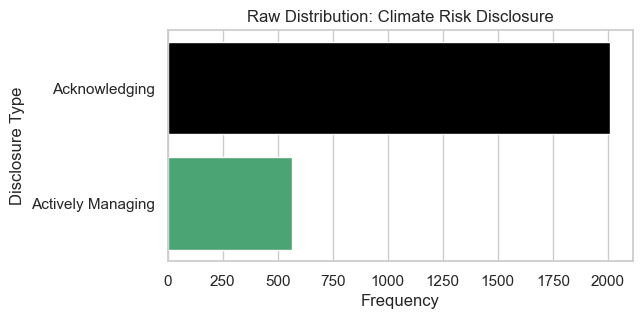

In [ ]:
# Distributions
sns.set_theme(style="whitegrid")

# 1. raw fistribution on sentence_count
plt.figure(figsize=(6,3))
sns.countplot(riskcomm_df['Risk_Disclosure'].dropna(), palette={
        'Acknowledging': 'black',
        'Actively Managing': 'mediumseagreen'
    })
plt.title('Raw Distribution: Climate Risk Disclosure')
plt.xlabel('Frequency')
plt.ylabel('Disclosure Type')
plt.xlim(left=0)

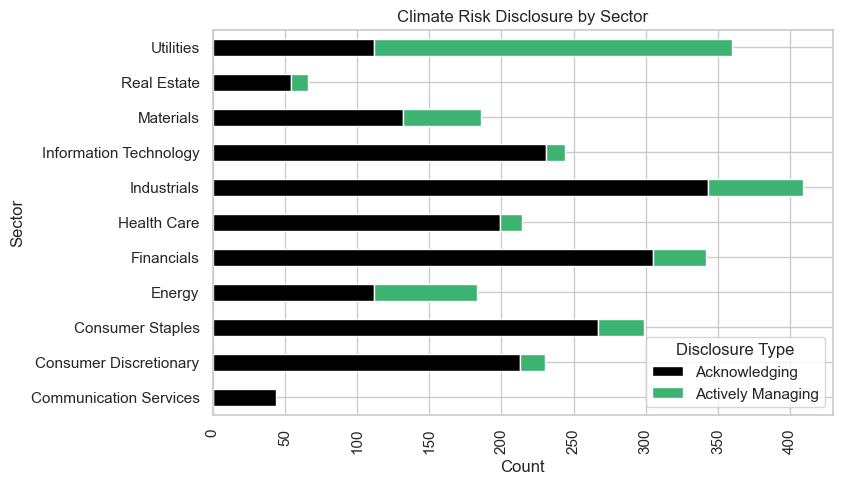

In [ ]:

# horizontal bar chart showing climate risk disclosure by sector
counts = pd.crosstab(riskcomm_df['sector'], riskcomm_df['Risk_Disclosure'])

colors = {
    'Actively Managing': 'mediumseagreen',
    'Acknowledging': 'black'
}

counts.plot(kind='barh', stacked=True, figsize=(8,5),  color=[colors[col] for col in counts.columns])
plt.title('Climate Risk Disclosure by Sector')
plt.xlabel('Count')
plt.ylabel('Sector')
plt.xticks(rotation = 90)
plt.legend(title='Disclosure Type')
plt.show()


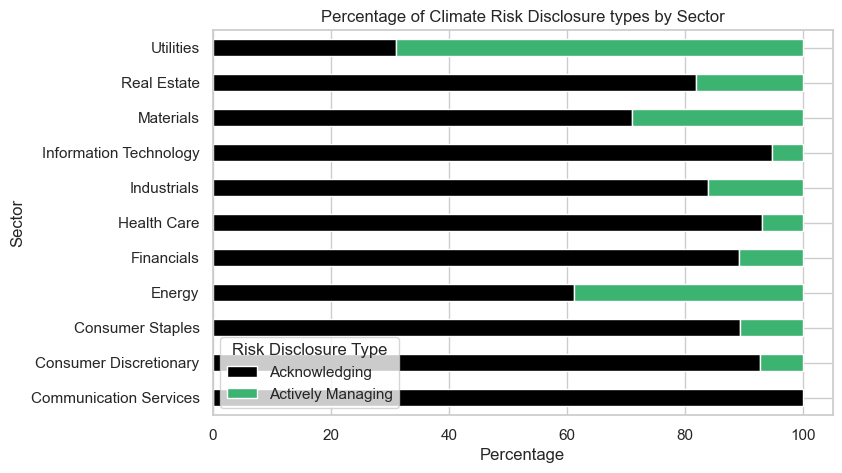

In [ ]:
# crosstable
counts_percent = counts.div(counts.sum(axis=1), axis=0) * 100


#  percentage of climate risk disclosure by type
counts_percent.plot(kind='barh', stacked=True, figsize=(8,5),color=[colors[col] for col in counts.columns])
plt.title('Percentage of Climate Risk Disclosure types by Sector')
plt.xlabel('Percentage')
plt.ylabel('Sector')
plt.legend(title='Risk Disclosure Type', loc='lower left')
plt.show()



C:\Users\TG2023\AppData\Local\Temp\ipykernel_23220\1241818651.py:6: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  pd.Grouper(key='FiscalYearEnd', freq='Y'),


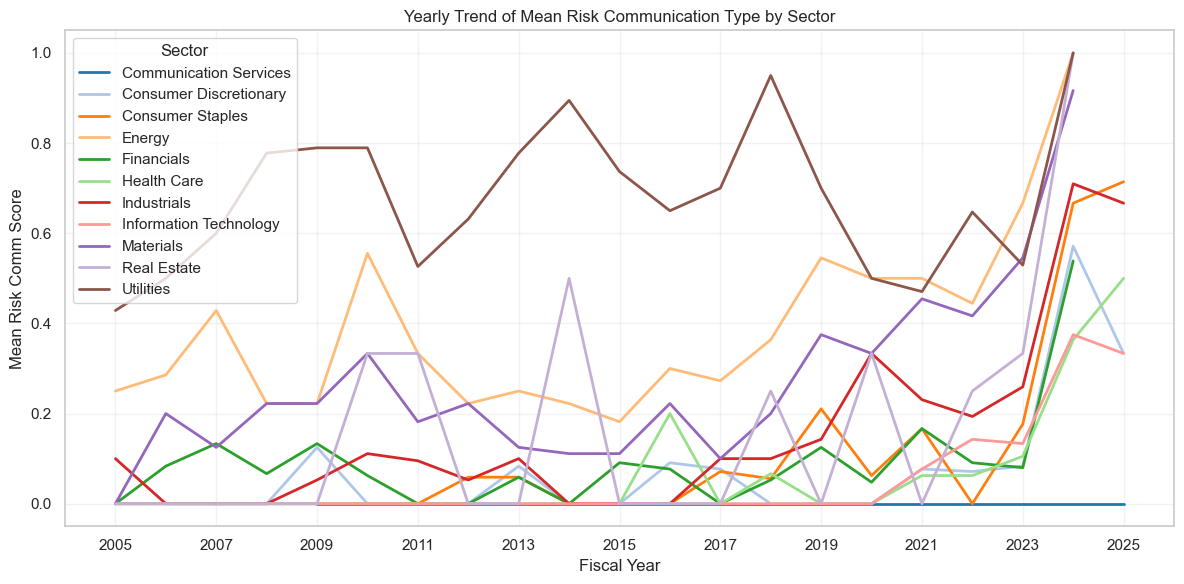

In [ ]:
# plotting yearly trend of mean risk communication
# fiscalyearend has to be datetime
riskcomm_df['FiscalYearEnd'] = pd.to_datetime(riskcomm_df['FiscalYearEnd'])

# yearly means by sector
pivot_yearly = riskcomm_df.groupby([
    pd.Grouper(key='FiscalYearEnd', freq='Y'),
    'sector'
])['Risk_comm_active'].mean().unstack()

plt.figure(figsize=(12,6))
colors = sns.color_palette("tab20", n_colors=len(pivot_yearly.columns))
years = pivot_yearly.index.year
plt.xticks(years[::2])
for col, c in zip(pivot_yearly.columns, colors):
    plt.plot(pivot_yearly.index.year, pivot_yearly[col],  linewidth=2, label=col, color=c)

plt.title('Yearly Trend of Mean Risk Communication Type by Sector')
plt.xlabel('Fiscal Year')
plt.ylabel('Mean Risk Comm Score')
plt.legend(title='Sector')
plt.grid(alpha=0.25)
plt.tight_layout()
plt.show()


C:\Users\TG2023\AppData\Local\Temp\ipykernel_23220\1786675080.py:5: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  yearly_avg = riskcomm_df.groupby(pd.Grouper(key='FiscalYearEnd', freq='Y'))['Risk_comm_active'].mean()


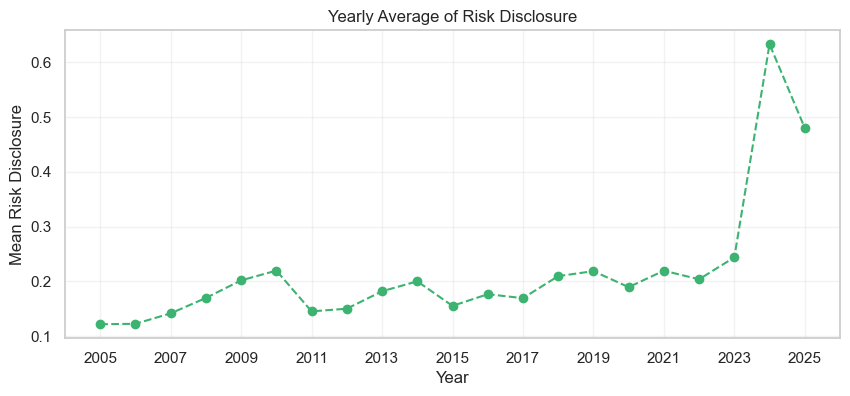

In [ ]:
# Time Series aggregated by Yearly average, Monthly average and daily average


# yearly average across all sectors
yearly_avg = riskcomm_df.groupby(pd.Grouper(key='FiscalYearEnd', freq='Y'))['Risk_comm_active'].mean()

plt.figure(figsize=(10,4))

plt.xticks(years[::2])
plt.plot(yearly_avg.index.year, yearly_avg,marker='o', color="mediumseagreen",linestyle="--")
plt.title('Yearly Average of Risk Disclosure')
plt.xlabel('Year')
plt.ylabel('Mean Risk Disclosure')
plt.grid(alpha=0.25)
plt.show()


C:\Users\TG2023\AppData\Local\Temp\ipykernel_23220\1635124433.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_avg = riskcomm_df.groupby(pd.Grouper(key='FiscalYearEnd', freq='M'))['Risk_comm_active'].mean()


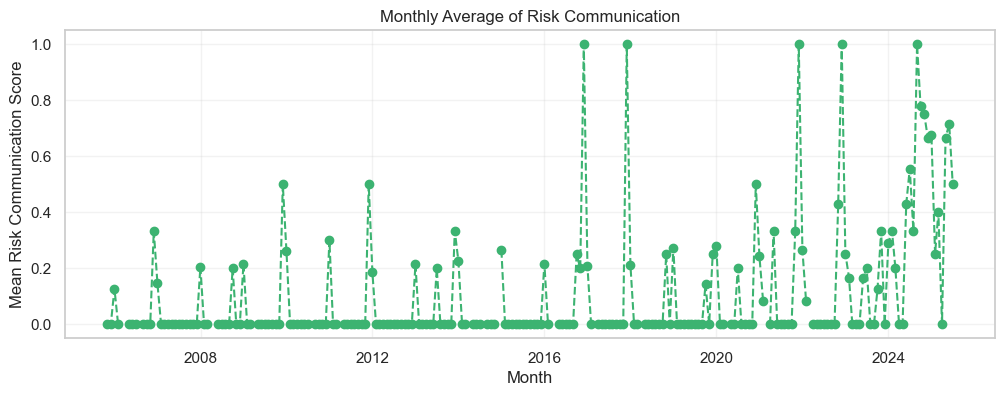

In [ ]:
# monthly average
monthly_avg = riskcomm_df.groupby(pd.Grouper(key='FiscalYearEnd', freq='M'))['Risk_comm_active'].mean()

plt.figure(figsize=(12,4))
plt.plot(monthly_avg.index, monthly_avg, marker='o',  color="mediumseagreen",linestyle="--")
plt.title('Monthly Average of Risk Communication')
plt.xlabel('Month')
plt.ylabel('Mean Risk Communication Score')
plt.grid(alpha=0.25)
plt.show()


In [ ]:
# Preparation for time series
# month average
ts = riskcomm_df.copy()
ts['FiscalYearEnd'] = pd.to_datetime(ts['FiscalYearEnd'])
ts.set_index('FiscalYearEnd', inplace=True)

ts['YearMonth'] = ts.index.to_period('M').to_timestamp()

# year average
ts['Year'] = ts.index.to_period('Y').to_timestamp()

# aggregate monthly
numeric_cols = ts.select_dtypes(include='number').columns
ts_month = ts.groupby('YearMonth')[numeric_cols].mean()

# aggreagate yearly
ts_year = ts.groupby('Year')[numeric_cols].mean()





In [348]:
full_month_index = ts_month.index
full_year_index = ts_year.index

In [ ]:
# new clean event sheet so we can copy above code
events = pd.read_csv("Events - Sheet1.csv")
regulations = pd.read_csv("Regulations - Sheet1.csv")
events = events.iloc[:-3]



events['Date '] = pd.to_datetime(events['Date '], format="%d-%m-%Y", errors='coerce')  # converts invalid to NaT
regulations['Date '] = pd.to_datetime(events['Date '], format="%d-%m-%Y", errors='coerce')  # converts invalid to NaT

print(events)

        Date                          Event   \
0  2004-09-21                 Hurricane Ivan   
1  2005-08-30              Hurricane Katrina   
2  2005-10-08             Kashmir Earthquake   
3  2007-11-16                   Cyclone Sidr   
4  2008-05-03                 Cyclone Nargis   
5  2008-09-14                  Hurricane Ive   
6  2010-01-12              Earthquake Haiti    
7  2011-03-11  Tsunami and Earthquake Japan    
8  2012-10-31               Hurricane Sandy    
9  2017-09-14                  Hurricanes US   
10 2018-09-16            Hurricane Florence    
11 2018-12-31          California wildfires    
12 2021-02-19               Winter storms US   
13 2021-09-01                  Hurricane Ida   
14 2022-09-08                  Hurricane Ian   
15 2023-02-06   Earthquake Syria and turkey    
16 2024-09-29              Hurricane Helene    

                                    Description  In_usa  
0           Cyclone - 34 bio$ damage - 57 dead      1.0  
1               Cyc

In [ ]:
# needs to be index for timeseries
events['Date '] = pd.to_datetime(events['Date '])
events.set_index('Date ', inplace=True)

events['YearMonth'] = events.index.to_period('M').to_timestamp()

# year column
events['Year'] = events.index.to_period('Y').to_timestamp()

# monthly aggregation
numeric_cols = events.select_dtypes(include='number').columns
events_month = events.groupby('YearMonth')[numeric_cols].mean()

# yearly aggregation
events_year = events.groupby('Year')[numeric_cols].mean()


In [ ]:
# same for regulations


regulations['Date'] = regulations['Date'].replace('16-2-2005', '16-02-2005')

regulations['Date'] = pd.to_datetime(regulations['Date'], dayfirst = True)

regulations.set_index('Date', inplace=True)

regulations['YearMonth'] = regulations.index.to_period('M').to_timestamp()


regulations['Year'] = regulations.index.to_period('Y').to_timestamp()


numeric_cols = regulations.select_dtypes(include='number').columns
regulations_month = regulations.groupby('YearMonth')[numeric_cols].mean()


regulations_year = regulations.groupby('Year')[numeric_cols].mean()


In [ ]:
# creating df with empty rows, for sarimax to work with events and regulations (seperately)
events['event'] = 1  # mark event occurrence
events_month = events.set_index('YearMonth', inplace=True)
events_month_full = events.reindex(full_month_index, fill_value=0)


In [353]:
events_year = events.copy()
events_year
events_year_full = events_year.reindex(full_year_index, fill_value=0)

In [354]:

regulations['regulation'] = 1  # mark event occurrence
regulations_month = regulations.set_index('YearMonth', inplace=True)
regulations_month_full = regulations.reindex(full_month_index, fill_value=0)

regulations_year = regulations.copy()
regulations_year
regulations_year_full = regulations_year.reindex(full_year_index, fill_value=0)

In [355]:
# fill nans with 0 

ts_month['event_next_month'] = events_month_full['event'].shift(1).fillna(0)
ts_month['regulation_next_month'] = regulations_month_full['regulation'].shift(1).fillna(0)

ts_year['event_next_year'] = events_year_full['event'].shift(1).fillna(0)
ts_year['regulation_next_year'] = regulations_year_full['regulation'].shift(1).fillna(0)



In [ ]:
# same as above: Monthly and Yearly SARIMAX but this time with RIsk COMMunication

# --- Monatsmodell: Events ---
model_events_month = SARIMAX(
    ts_month['Risk_comm_active'],
    exog=ts_month[['event_next_month']],
    order=(1,0,0)
)
result_events_month = model_events_month.fit()
print("Monatsmodell - Events")
print(result_events_month.summary())

# --- Monatsmodell: Regulations ---

model_reg_month = SARIMAX(
    ts_month['Risk_comm_active'],
    exog=ts_month[['regulation_next_month']],
    order=(1,0,0)
)
result_reg_month = model_reg_month.fit()
print("Monatsmodell - Regulations")
print(result_reg_month.summary())

# --- Jahresmodell: Events ---

model_events_year = SARIMAX(
    ts_year['Risk_comm_active'],
    exog=ts_year[['event_next_year']],
    order=(1,0,0)
)
result_events_year = model_events_year.fit()
print("Jahresmodell - Events")
print(result_events_year.summary())

# --- Jahresmodell: Regulations ---

model_reg_year = SARIMAX(
    ts_year['Risk_comm_active'],
    exog=ts_year[['regulation_next_year']],
    order=(1,0,0)
)
result_reg_year = model_reg_year.fit()
print("Jahresmodell - Regulations")
print(result_reg_year.summary())


Monatsmodell - Events
                               SARIMAX Results                                
Dep. Variable:       Risk_comm_active   No. Observations:                  219
Model:               SARIMAX(1, 0, 0)   Log Likelihood                  48.429
Date:                 So, 31 Aug 2025   AIC                            -90.857
Time:                        12:19:59   BIC                            -80.690
Sample:                             0   HQIC                           -86.751
                                - 219                                         
Covariance Type:                  opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
event_next_month    -0.0247      0.036     -0.693      0.489      -0.095       0.045
ar.L1                0.5831      0.038     15.207      0.000       0.508       0.658
sigma2

c:\Users\TG2023\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\TG2023\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\TG2023\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\TG2023\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(d

In [ ]:
# Now for 1-6 MOnths
# --- Events für 6 Monate vorbereiten ---
for i in range(1, 7):
    ts_month[f'event_next_{i}month'] = events_month_full['event'].shift(i).fillna(0)

event_exog_cols = [f'event_next_{i}month' for i in range(1, 7)]

# SARIMAX für Events
model_events_6m = SARIMAX(ts_month['Risk_comm_active'],
                          exog=ts_month[event_exog_cols],
                          order=(1,0,0))
result_events_6m = model_events_6m.fit()
print("Monatliches Modell - Events (6 Monate):")
print(result_events_6m.summary())

# --- Regulations für 6 Monate vorbereiten ---
for i in range(1, 7):
    ts_month[f'regulation_next_{i}month'] = regulations_month_full['regulation'].shift(i).fillna(0)

reg_exog_cols = [f'regulation_next_{i}month' for i in range(1, 7)]

# SARIMAX für Regulations
model_reg_6m = SARIMAX(ts_month['Risk_comm_active'],
                        exog=ts_month[reg_exog_cols],
                        order=(1,0,0))
result_reg_6m = model_reg_6m.fit()
print("Monatliches Modell - Regulations (6 Monate):")
print(result_reg_6m.summary())
# check results - different to previous??? --> Verzerrung durch Korrelation zwischen mehreren Lags.

c:\Users\TG2023\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\TG2023\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\TG2023\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\TG2023\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(d

Monatliches Modell - Events (6 Monate):
                               SARIMAX Results                                
Dep. Variable:       Risk_comm_active   No. Observations:                  219
Model:               SARIMAX(1, 0, 0)   Log Likelihood                  60.975
Date:                 So, 31 Aug 2025   AIC                           -105.949
Time:                        12:20:05   BIC                            -78.837
Sample:                             0   HQIC                           -94.999
                                - 219                                         
Covariance Type:                  opg                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
event_next_1month     0.1139      0.058      1.968      0.049       0.000       0.227
event_next_2month     0.2982      0.042      7.073      0.000       0.

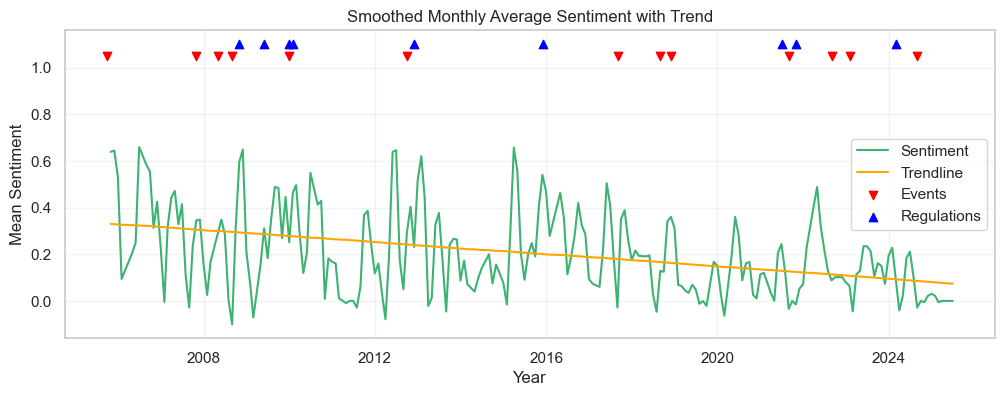

In [ ]:
# Line Plot with Events, regulations and trendline for Sentiment (smoothing for better visuals)

# Monatsdurchschnitt, NaNs entfernen
monthly_avg_clean = monthly_avg.dropna()

# Glättung (Fenster 5 Monate, Polynomgrad 2)
smoothed = savgol_filter(monthly_avg_clean.values, window_length=5, polyorder=2)

# Trendlinie berechnen (linear)
x = np.arange(len(smoothed))
trend_coeff = np.polyfit(x, smoothed, 1)
trendline = np.polyval(trend_coeff, x)

plt.figure(figsize=(12,4))

# Geglättete Kurve
plt.plot(monthly_avg_clean.index, smoothed, color='mediumseagreen', label='Sentiment')

# Trendlinie
plt.plot(monthly_avg_clean.index, trendline, color='orange', linestyle='-', label='Trendline')

# Events hinzufügen
plt.scatter(events_month_true.index, [monthly_avg_clean.max()*1.05]*len(events_month_true), 
            color='red', marker='v', label='Events')

# Regulations hinzufügen
plt.scatter(regulations_month_true.index, [monthly_avg_clean.max()*1.1]*len(regulations_month_true), 
            color='blue', marker='^', label='Regulations')

plt.title('Smoothed Monthly Average Sentiment with Trend')
plt.xlabel('Year')
plt.ylabel('Mean Sentiment')
plt.grid(alpha=0.25)
plt.legend()
plt.show()


In [ ]:
# checking if trendline is significant linear regression

# NaNs entfernen (sollte schon clean sein, sicherheitshalber)
monthly_avg_clean = monthly_avg.dropna()

y = monthly_avg_clean.values
x = np.arange(len(monthly_avg_clean))

# Intercept hinzufügen
x = sm.add_constant(x)

# OLS Regression
model = sm.OLS(y, x).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.083
Model:                            OLS   Adj. R-squared:                  0.078
Method:                 Least Squares   F-statistic:                     19.52
Date:                 So, 31 Aug 2025   Prob (F-statistic):           1.57e-05
Time:                        12:52:56   Log-Likelihood:                -6.4573
No. Observations:                 219   AIC:                             16.91
Df Residuals:                     217   BIC:                             23.69
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3310      0.034      9.818      0.0

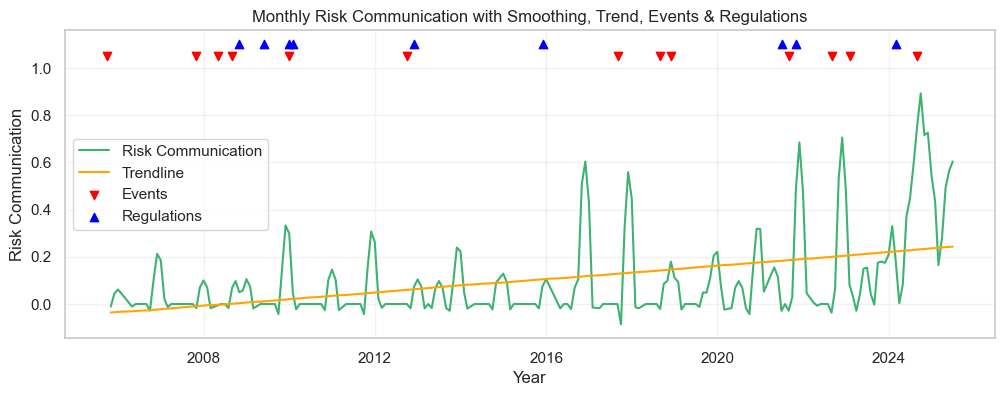

In [ ]:
# same for risk communication

# Nur Monate mit Events/Regulations = 1
events_month_true = events_month_full[events_month_full['event'] == 1]
regulations_month_true = regulations_month_full[regulations_month_full['regulation'] == 1]

# NaNs entfernen
monthly_risk_clean = monthly_risk.dropna()

# Fenster für Savitzky-Golay anpassen
window = min(5, len(monthly_risk_clean))
if window % 2 == 0:
    window -= 1  # sicherstellen, dass ungerade

# Glättung
smoothed = savgol_filter(monthly_risk_clean.values, window_length=window, polyorder=2)

plt.figure(figsize=(12,4))



# Geglättete Kurve
plt.plot(monthly_risk_clean.index, smoothed, color="mediumseagreen",  label="Risk Communication")

# Trendlinie
x = np.arange(len(smoothed))
trend_coeff = np.polyfit(x, smoothed, 1)
trendline = np.polyval(trend_coeff, x)
plt.plot(monthly_risk_clean.index, trendline, color='orange',  label='Trendline')


# Events
plt.scatter(events_month_true.index, [monthly_risk_clean.max()*1.05]*len(events_month_true), color='red', marker='v', label='Events')

# Regulations
plt.scatter(regulations_month_true.index, [monthly_risk_clean.max()*1.1]*len(regulations_month_true), color='blue', marker='^', label='Regulations')

plt.title('Monthly Risk Communication with Smoothing, Trend, Events & Regulations')
plt.xlabel('Year')
plt.ylabel('Risk Communication')
plt.legend(loc="center left")
plt.grid(alpha=0.25)
plt.show()


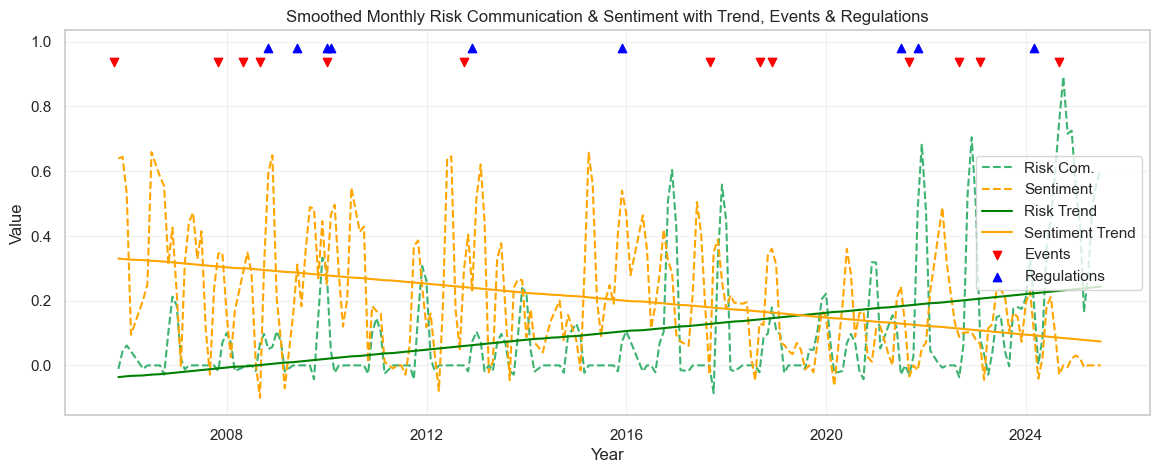

In [ ]:
# risk comm and sentiment together - trying different visual settings
# NaNs entfernen
monthly_risk_clean = monthly_risk.dropna()
monthly_sentiment_clean = monthly_avg_clean.dropna()  # oder monthly_sentiment.dropna()

# Fenster für Savitzky-Golay anpassen
window_risk = min(5, len(monthly_risk_clean))
if window_risk % 2 == 0: window_risk -= 1

window_sent = min(5, len(monthly_sentiment_clean))
if window_sent % 2 == 0: window_sent -= 1

# Glättung
smoothed_risk = savgol_filter(monthly_risk_clean.values, window_length=window_risk, polyorder=2)
smoothed_sent = savgol_filter(monthly_sentiment_clean.values, window_length=window_sent, polyorder=2)

# Trendlinien
x_risk = np.arange(len(smoothed_risk))
trend_risk = np.polyval(np.polyfit(x_risk, smoothed_risk, 1), x_risk)

x_sent = np.arange(len(smoothed_sent))
trend_sent = np.polyval(np.polyfit(x_sent, smoothed_sent, 1), x_sent)

# Events & Regulations
events_month_true = events_month_full[events_month_full['event'] == 1]
regulations_month_true = regulations_month_full[regulations_month_full['regulation'] == 1]

plt.figure(figsize=(14,5))

# Geglättete Kurven
plt.plot(monthly_risk_clean.index, smoothed_risk, color="mediumseagreen", linestyle="--", label="Risk Com.")
plt.plot(monthly_sentiment_clean.index, smoothed_sent, color="orange", linestyle="--", label="Sentiment")

# Trendlinien
plt.plot(monthly_risk_clean.index, trend_risk, color='green', linestyle='-', label='Risk Trend')
plt.plot(monthly_sentiment_clean.index, trend_sent, color='orange', linestyle='-', label='Sentiment Trend')

# Events & Regulations
plt.scatter(events_month_true.index, [max(smoothed_risk.max(), smoothed_sent.max())*1.05]*len(events_month_true), 
            color='red', marker='v', label='Events')
plt.scatter(regulations_month_true.index, [max(smoothed_risk.max(), smoothed_sent.max())*1.1]*len(regulations_month_true), 
            color='blue', marker='^', label='Regulations')

plt.title('Smoothed Monthly Risk Communication & Sentiment with Trend, Events & Regulations')
plt.xlabel('Year')
plt.ylabel('Value')
plt.legend(loc="center right")
plt.grid(alpha=0.25)
plt.show()


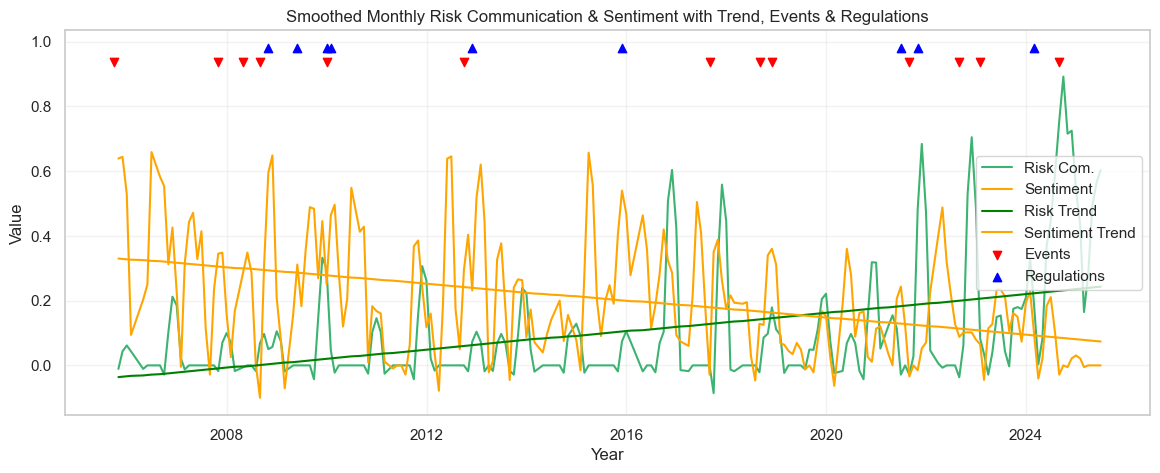

In [ ]:
# risk comm and sentiment together - trying different visual settings
# NaNs entfernen
monthly_risk_clean = monthly_risk.dropna()
monthly_sentiment_clean = monthly_avg_clean.dropna()  # oder monthly_sentiment.dropna()

# Fenster für Savitzky-Golay anpassen
window_risk = min(5, len(monthly_risk_clean))
if window_risk % 2 == 0: window_risk -= 1

window_sent = min(5, len(monthly_sentiment_clean))
if window_sent % 2 == 0: window_sent -= 1

# Glättung
smoothed_risk = savgol_filter(monthly_risk_clean.values, window_length=window_risk, polyorder=2)
smoothed_sent = savgol_filter(monthly_sentiment_clean.values, window_length=window_sent, polyorder=2)

# Trendlinien
x_risk = np.arange(len(smoothed_risk))
trend_risk = np.polyval(np.polyfit(x_risk, smoothed_risk, 1), x_risk)

x_sent = np.arange(len(smoothed_sent))
trend_sent = np.polyval(np.polyfit(x_sent, smoothed_sent, 1), x_sent)

# Events & Regulations
events_month_true = events_month_full[events_month_full['event'] == 1]
regulations_month_true = regulations_month_full[regulations_month_full['regulation'] == 1]

plt.figure(figsize=(14,5))

# Geglättete Kurven
plt.plot(monthly_risk_clean.index, smoothed_risk, color="mediumseagreen",  label="Risk Com.")
plt.plot(monthly_sentiment_clean.index, smoothed_sent, color="orange", label="Sentiment")

# Trendlinien
plt.plot(monthly_risk_clean.index, trend_risk, color='green', linestyle='-', label='Risk Trend')
plt.plot(monthly_sentiment_clean.index, trend_sent, color='orange', linestyle='-', label='Sentiment Trend')

# Events & Regulations
plt.scatter(events_month_true.index, [max(smoothed_risk.max(), smoothed_sent.max())*1.05]*len(events_month_true), 
            color='red', marker='v', label='Events')
plt.scatter(regulations_month_true.index, [max(smoothed_risk.max(), smoothed_sent.max())*1.1]*len(regulations_month_true), 
            color='blue', marker='^', label='Regulations')

plt.title('Smoothed Monthly Risk Communication & Sentiment with Trend, Events & Regulations')
plt.xlabel('Year')
plt.ylabel('Value')
plt.legend(loc="center right")
plt.grid(alpha=0.25)
plt.show()


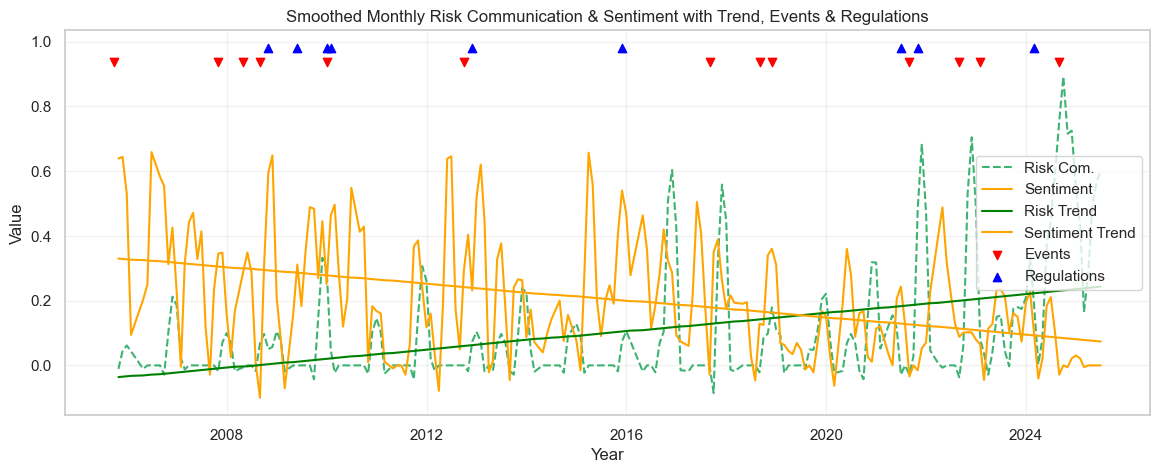

In [ ]:
# risk comm and sentiment together - trying different visual settings - this looks best
# NaNs entfernen
monthly_risk_clean = monthly_risk.dropna()
monthly_sentiment_clean = monthly_avg_clean.dropna()  # oder monthly_sentiment.dropna()

# Fenster für Savitzky-Golay anpassen
window_risk = min(5, len(monthly_risk_clean))
if window_risk % 2 == 0: window_risk -= 1

window_sent = min(5, len(monthly_sentiment_clean))
if window_sent % 2 == 0: window_sent -= 1

# Glättung
smoothed_risk = savgol_filter(monthly_risk_clean.values, window_length=window_risk, polyorder=2)
smoothed_sent = savgol_filter(monthly_sentiment_clean.values, window_length=window_sent, polyorder=2)

# Trendlinien
x_risk = np.arange(len(smoothed_risk))
trend_risk = np.polyval(np.polyfit(x_risk, smoothed_risk, 1), x_risk)

x_sent = np.arange(len(smoothed_sent))
trend_sent = np.polyval(np.polyfit(x_sent, smoothed_sent, 1), x_sent)

# Events & Regulations
events_month_true = events_month_full[events_month_full['event'] == 1]
regulations_month_true = regulations_month_full[regulations_month_full['regulation'] == 1]

plt.figure(figsize=(14,5))

# Geglättete Kurven
plt.plot(monthly_risk_clean.index, smoothed_risk, color="mediumseagreen",linestyle='--',  label="Risk Com.")
plt.plot(monthly_sentiment_clean.index, smoothed_sent, color="orange", label="Sentiment")

# Trendlinien
plt.plot(monthly_risk_clean.index, trend_risk, color='green', linestyle='-', label='Risk Trend')
plt.plot(monthly_sentiment_clean.index, trend_sent, color='orange', linestyle='-', label='Sentiment Trend')

# Events & Regulations
plt.scatter(events_month_true.index, [max(smoothed_risk.max(), smoothed_sent.max())*1.05]*len(events_month_true), 
            color='red', marker='v', label='Events')
plt.scatter(regulations_month_true.index, [max(smoothed_risk.max(), smoothed_sent.max())*1.1]*len(regulations_month_true), 
            color='blue', marker='^', label='Regulations')

plt.title('Smoothed Monthly Risk Communication & Sentiment with Trend, Events & Regulations')
plt.xlabel('Year')
plt.ylabel('Value')
plt.legend(loc="center right")
plt.grid(alpha=0.25)
plt.show()


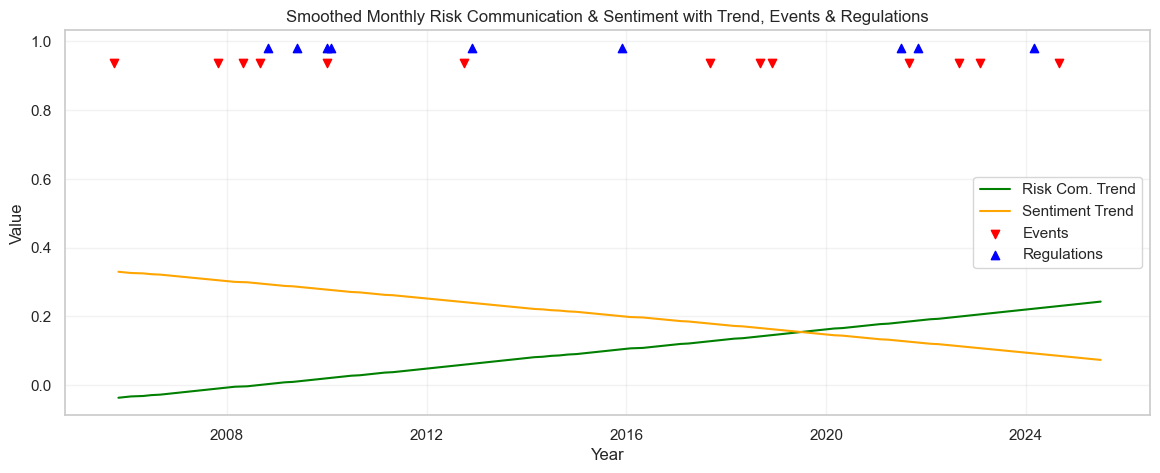

In [ ]:
# risk comm and sentiment together - trying different visual settings - most minimalistic, but lacking information
# NaNs entfernen
monthly_risk_clean = monthly_risk.dropna()
monthly_sentiment_clean = monthly_avg_clean.dropna()  # oder monthly_sentiment.dropna()

# Fenster für Savitzky-Golay anpassen
window_risk = min(5, len(monthly_risk_clean))
if window_risk % 2 == 0: window_risk -= 1

window_sent = min(5, len(monthly_sentiment_clean))
if window_sent % 2 == 0: window_sent -= 1

# Glättung
smoothed_risk = savgol_filter(monthly_risk_clean.values, window_length=window_risk, polyorder=2)
smoothed_sent = savgol_filter(monthly_sentiment_clean.values, window_length=window_sent, polyorder=2)

# Trendlinien
x_risk = np.arange(len(smoothed_risk))
trend_risk = np.polyval(np.polyfit(x_risk, smoothed_risk, 1), x_risk)

x_sent = np.arange(len(smoothed_sent))
trend_sent = np.polyval(np.polyfit(x_sent, smoothed_sent, 1), x_sent)

# Events & Regulations
events_month_true = events_month_full[events_month_full['event'] == 1]
regulations_month_true = regulations_month_full[regulations_month_full['regulation'] == 1]

plt.figure(figsize=(14,5))



# Trendlinien
plt.plot(monthly_risk_clean.index, trend_risk, color='green', linestyle='-', label='Risk Com. Trend')
plt.plot(monthly_sentiment_clean.index, trend_sent, color='orange', linestyle='-', label='Sentiment Trend')

# Events & Regulations
plt.scatter(events_month_true.index, [max(smoothed_risk.max(), smoothed_sent.max())*1.05]*len(events_month_true), 
            color='red', marker='v', label='Events')
plt.scatter(regulations_month_true.index, [max(smoothed_risk.max(), smoothed_sent.max())*1.1]*len(regulations_month_true), 
            color='blue', marker='^', label='Regulations')

plt.title('Smoothed Monthly Risk Communication & Sentiment with Trend, Events & Regulations')
plt.xlabel('Year')
plt.ylabel('Value')
plt.legend(loc="center right")
plt.grid(alpha=0.25)
plt.show()


In [ ]:
# checking if trendline of risk communication is significant linear regression

# NaNs entfernen
mask = ~np.isnan(monthly_risk.values)
y = monthly_risk.values[mask]
x = np.arange(len(monthly_risk))[mask]

# Intercept hinzufügen
x = sm.add_constant(x)

model = sm.OLS(y, x).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.145
Model:                            OLS   Adj. R-squared:                  0.141
Method:                 Least Squares   F-statistic:                     36.68
Date:                 So, 31 Aug 2025   Prob (F-statistic):           6.07e-09
Time:                        12:51:43   Log-Likelihood:                 45.187
No. Observations:                 219   AIC:                            -86.37
Df Residuals:                     217   BIC:                            -79.60
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0382      0.027     -1.414      0.1

C:\Users\TG2023\AppData\Local\Temp\ipykernel_23220\2512144062.py:6: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_risk = riskcomm_df.groupby(pd.Grouper(key='FiscalYearEnd', freq='M'))['Risk_comm_active'].mean()
C:\Users\TG2023\AppData\Local\Temp\ipykernel_23220\2512144062.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_sentiment = sentiment_df.groupby(pd.Grouper(key='FiscalYearEnd', freq='M'))['full_sentiment_id'].mean()


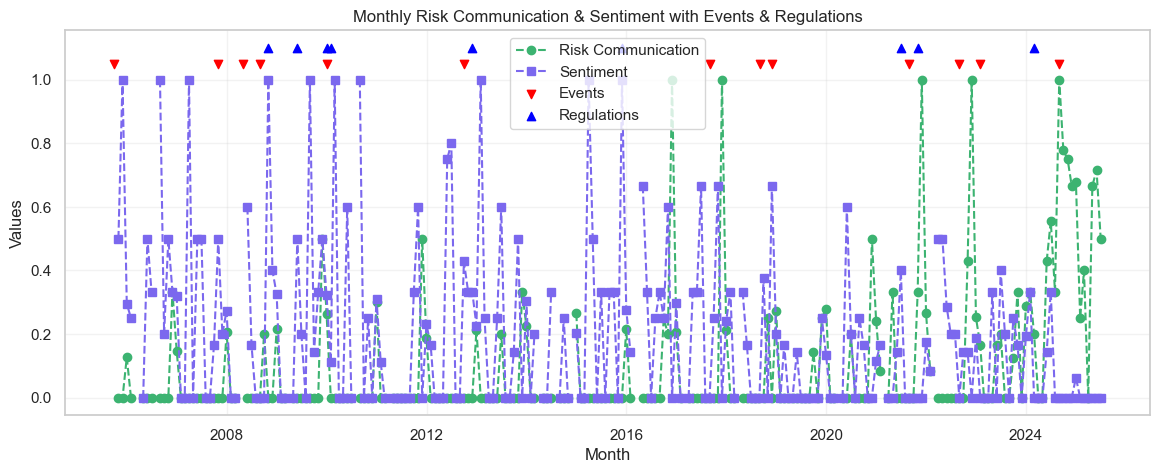

In [ ]:
# risk comm and sentiment together - trying different visual settings - no smoothing is cluttered
# Sicherstellen, dass Datumsangaben datetime sind
riskcomm_df['FiscalYearEnd'] = pd.to_datetime(riskcomm_df['FiscalYearEnd'], dayfirst=True)
sentiment_df['FiscalYearEnd'] = pd.to_datetime(sentiment_df['FiscalYearEnd'], dayfirst=True)

# Monatsdurchschnitt berechnen
monthly_risk = riskcomm_df.groupby(pd.Grouper(key='FiscalYearEnd', freq='M'))['Risk_comm_active'].mean()
monthly_sentiment = sentiment_df.groupby(pd.Grouper(key='FiscalYearEnd', freq='M'))['full_sentiment_id'].mean()

# Nur Monate mit Events/Regulations = 1
events_true = events_month_full[events_month_full['event'] == 1]
regs_true = regulations_month_full[regulations_month_full['regulation'] == 1]

plt.figure(figsize=(14,5))

# Risk Communication
plt.plot(monthly_risk.index, monthly_risk, marker='o', color="mediumseagreen", linestyle="--", label="Risk Communication")

# Sentiment
plt.plot(monthly_sentiment.index, monthly_sentiment, marker='s', color="mediumslateblue", linestyle="--", label="Sentiment")

# Events hinzufügen
plt.scatter(events_true.index, [max(monthly_risk.max(), monthly_sentiment.max())*1.05]*len(events_true), 
            color='red', marker='v', label='Events')

# Regulations hinzufügen
plt.scatter(regs_true.index, [max(monthly_risk.max(), monthly_sentiment.max())*1.1]*len(regs_true), 
            color='blue', marker='^', label='Regulations')

plt.title('Monthly Risk Communication & Sentiment with Events & Regulations')
plt.xlabel('Month')
plt.ylabel('Values')
plt.legend()
plt.grid(alpha=0.25)
plt.show()
